Чтобы сдать задание, выполните следующую последовательность действий.

1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.
2. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.
3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.
4. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.
5. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.
6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.
7. Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
import folium
import json
import geojson
from folium import plugins
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.basemap import Basemap

In [3]:
with open('data_week1.pkl', 'rb') as file:
    data = pickle.load(file)
#print(data)

In [4]:
with open('regions_week1.pkl', 'rb') as file:
    regions = pickle.load(file)
#print(regions)

In [5]:
ny_coordinates = [[ -74.25559, -73.70001],[40.91553, 40.49612]]
NY_west = ny_coordinates[0][0]
NY_east = ny_coordinates[0][1]
NY_north = ny_coordinates[1][0]
NY_south =  ny_coordinates[1][1]
ESB_long = -73.985664
ESB_lat  =  40.748441
SoL_lat = 40.6892776
SoL_long= -74.0445938

## Загрузка данных и подсчет 0-ых ячеек за май 2016

In [153]:
non_zero = np.count_nonzero( regions.iloc[:,5:] != 0.0)
zero = np.count_nonzero( regions.iloc[:,5:] == 0.0)

regions['count_trips'] = sum(regions.iloc[:, 5:])
summ = []
zero_trips = 0
for i in range(len(regions.count_trips)):
    summ.append(sum(np.array((regions.iloc[i,5:-1]))))
regions['count_trips'] = summ
for i in range(len(regions.count_trips)):
    if regions.count_trips.iloc[i] == 0:
        zero_trips +=1
print('Количество ячеек с 0 поездок:', zero_trips)

Количество ячеек с 0 поездок: 0


Количество поездок на такси по регионам: (для примера регионы с 1225 по 1235)

In [8]:
regions.count_trips[1225:1235]

1225      2662.0
1226    120597.0
1227    236281.0
1228    312521.0
1229    476106.0
1230    489489.0
1231    552503.0
1232    394985.0
1233    265118.0
1234    114977.0
Name: count_trips, dtype: float64

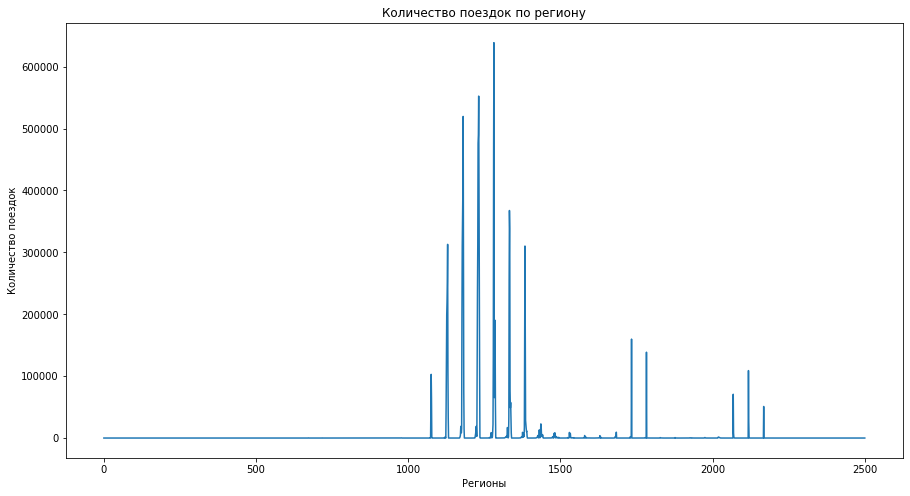

In [9]:
plt.figure(figsize=(15,8))
plt.plot(regions.region, regions.count_trips)
plt.xlabel('Регионы')
plt.ylabel('Количество поездок')
plt.title('Количество поездок по региону')
plt.show()

##  Карта Нью-Йорка

In [154]:
def data2geojson(df):
    '''
    Преобразует координаты датафрейма в мултиполигон формата GeoJson
    '''
    features = []
    insert_features = lambda X: features.append(
        geojson.Feature(geometry = geojson.Polygon([[(X['west'], X['south']),
                                                     (X['east'], X['south']),
                                                     (X['east'], X['north']),
                                                     (X['west'], X['north'])]]),
                        id = str(X.name)))
    df.apply(insert_features, axis = 1)
    feature_collection = geojson.FeatureCollection(features)
    dumps = geojson.dumps(feature_collection)
    return geojson.loads(dumps)

In [160]:
regions.iloc[:,1:5]

,west,east,south,north
0,-74.255590,-74.244478,40.496120,40.504508
1,-74.255590,-74.244478,40.504508,40.512896
2,-74.255590,-74.244478,40.512896,40.521285
3,-74.255590,-74.244478,40.521285,40.529673
4,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...
2495,-73.711122,-73.700010,40.873589,40.881977
2496,-73.711122,-73.700010,40.881977,40.890365
2497,-73.711122,-73.700010,40.890365,40.898754
2498,-73.711122,-73.700010,40.898754,40.907142


In [161]:
geo_data = data2geojson(regions.iloc[:,1:5])

In [11]:
longit = np.unique(regions[['west', 'east']].values)
latit  = np.unique(regions[['north', 'south']].values)
long, latt = np.meshgrid(longit, latit)

In [12]:
data_reg_aggr = regions.sum(axis=1)

In [178]:
regions

,region,west,east,south,north,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,...,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00,count_trips,mean_trips
0,1,-74.255590,-74.244478,40.496120,40.504508,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,2,-74.255590,-74.244478,40.504508,40.512896,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,3,-74.255590,-74.244478,40.512896,40.521285,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,4,-74.255590,-74.244478,40.521285,40.529673,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4,5,-74.255590,-74.244478,40.529673,40.538061,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2496,2497,-73.711122,-73.700010,40.881977,40.890365,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2497,2498,-73.711122,-73.700010,40.890365,40.898754,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2498,2499,-73.711122,-73.700010,40.898754,40.907142,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [177]:
data_reg_aggr

0        -66.499440
1        -65.482664
2        -64.465887
3        -63.449111
4        -62.432335
           ...     
2495    2430.344435
2496    2431.361211
2497    2432.377987
2498    2433.394764
2499    2434.411540
Length: 2500, dtype: float64

C:\Users\Dronz\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


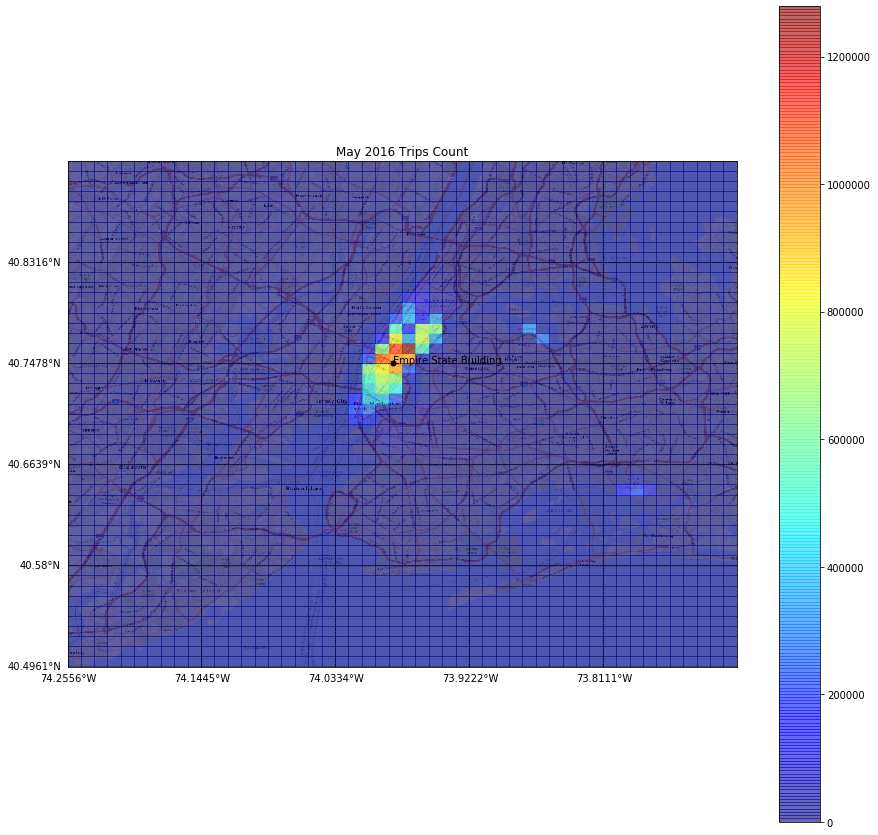

In [13]:
plt.figure(figsize=(15,15))
map_basemap = Basemap(llcrnrlat=(NY_south),
                      llcrnrlon=(NY_west), 
                      urcrnrlat=(NY_north),
                      urcrnrlon=(NY_east), 
                      resolution='f',
                      projection='lcc',
                      area_thresh=5000,
                     lat_0=(NY_north + NY_north)/2.0,
                     lon_0=(NY_west + NY_east)/2.0,
                      epsg=4326)

#Визуализация на карте районы с вызовом такси
map_basemap.pcolormesh(long,
                       latt, 
                       data_reg_aggr.values.reshape(50,50).transpose(), 
                       latlon=True, 
                       cmap='jet',
                       alpha=0.6)
map_basemap.shadedrelief()
map_basemap.bluemarble()
x,y = map_basemap(ESB_long , ESB_lat)
plt.plot(x,y, 'ok', markersize=5)
plt.text(x,y,'Empire State Building', fontsize=10);
map_basemap.arcgisimage(service='World_Street_Map', xpixels=1200, epsg=4326)
plt.colorbar()

parallels = np.arange(NY_south,NY_north, (NY_north - NY_south)/5)
map_basemap.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(NY_west,NY_east, (NY_east - NY_west)/5)
map_basemap.drawmeridians(meridians,labels=[True,False,False,True])

plt.title('May 2016 Trips Count')
plt.show()

Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [14]:
#!pip install folium

In [17]:
#!pip install geojson

In [19]:
map_folium = folium.Map(location=[SoL_lat, SoL_long], titles='cartodbpositron')
folium.Marker(location=[SoL_lat, SoL_long],
                 popup='State of Liberty').add_to(map_folium)
folium.Marker(location=[ESB_lat, ESB_long],
                 popup='Empire State Building').add_to(map_folium)
map_folium

Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [20]:
#среднее количество поездок за месяц 
mean_trips = []
for i in range(len(regions)):
    mean_trips.append(regions.count_trips[i]/24)
regions['mean_trips'] = mean_trips

In [21]:
mm = []
for i in range(len(regions)):
    mm.append(mean(regions.count_trips[i]))

In [176]:
mean = pd.DataFrame(regions.count_trips.mean(axis=0))

ValueError: DataFrame constructor not properly called!

In [136]:
feat = []
for i in regions.index:
    poly = geojson.Polygon([[regions.iloc[i].west, regions.iloc[i].south],
                             [regions.iloc[i].west, regions.iloc[i].north],
                             [regions.iloc[i].east, regions.iloc[i].north], 
                             [regions.iloc[i].east, regions.iloc[i].south],
                             [regions.iloc[i].west, regions.iloc[i].south]])
    features = geojson.Feature(geometry=poly, id=str(i), properties={"name": "region {}".format(int(regions.iloc[i].region))})
    feat.append(features)
feach = geojson.FeatureCollection(feat)   
with open('regions.json', 'w') as file:
    json.dump(feach, file)

In [137]:
print(file)

<_io.TextIOWrapper name='regions.json' mode='w' encoding='cp1251'>


In [143]:
vmin = data_reg_a.min()
vmax = data_reg_a.max()
width = vmax-vmin
color = cm.LinearColormap(['white', 'green', 'cyan', 'blue', 'magenta', 'red'],
                               vmax = vmax, vmin = vmin,
                               index=[vmin, 20, 0.3*width, 0.6*width, 0.9*width, 1.0*vmax])
color

In [112]:
regions_left = []
for ind, val in enumerate(mean_trips):
    if val >= 5:
        regions_left.append(int(ind))

In [114]:
len(regions_left)

272

In [141]:
data_reg_a = regions.sum(axis=1)

In [142]:
(data_reg_a == 0).sum

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
2495    False
2496    False
2497    False
2498    False
2499    False
Length: 2500, dtype: bool>

In [118]:
def custom_color_map(value):
    global regions_left
    if value in regions_left:
        return ('#008000')
    else:
        return ('#ff0000')

In [150]:
map_folium2 = folium.Map(location=[SoL_lat, SoL_long], titles='cartodbpositron', zoom_start=10)
folium.Marker(location=[SoL_lat, SoL_long],
                 popup='State of Liberty').add_to(map_folium2)
folium.Marker(location=[ESB_lat, ESB_long],
                 popup='Empire State Building').add_to(map_folium2)


folium.GeoJson(
    feach,
    style_function=lambda feacher: {
        'fillColor': color(data_reg_a[int(feacher['id'])]),
        'color': 'black',
        'weight': 0.2,
        'dashArray': '5, 5'
    }
).add_to(map_folium2)

color.caption = 'Mean trips'
map_folium2.add_child(color)
map_folium2

In [174]:
folium.Marker(location=[SoL_lat, SoL_long],
                 popup='State of Liberty').add_to(map_folium2)
folium.Marker(location=[ESB_lat, ESB_long],
                 popup='Empire State Building').add_to(map_folium2)

map_folium2 = folium.Map(location = [SoL_lat, SoL_long], zoom_start = 11, control_scale = True, attr='USGS style')
folium.Choropleth(
    geo_data = geo_data,
    data = mean_trips,
   columns = ['id', 'value'],
   key_on = 'id',
   fill_color = 'BuPu',
    legend_name = u'Среднее число поездок в час',
   fill_opacity=0.7,
    line_opacity=0.2).add_to(map_folium2)
map_folium2

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [73]:
print('Количество регионов с поездками меньше 5:', (regions.count_trips.values < 5).sum())

Количество регионов с поездками меньше 5: 1759


In [106]:
cnt = 0
for i in regions.mean_trips:
    if i <= 5.:
        cnt +=1
print('Количество поездками меньше 5:', cnt)

Количество поездками меньше 5: 2229



7. Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки).

In [108]:
# jupyter nbconvert --to html taxi 2.ipynb  

SyntaxError: invalid syntax (<ipython-input-108-82f9d90cc45e>, line 1)